<a href="https://colab.research.google.com/github/takedatmh/toyama/blob/main/LLM_FineTuning_Pruning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1 PyTorch による簡単なPruning例

## 4Layer-4Nodeの全結合のNNを作成して、20%の重みを削減

In [ ]:
import torch
import torch.nn.utils.prune as prune
import torch.nn as nn

# 線形層の定義
linear = nn.Linear(4, 4)
print("元の重み：\n", linear.weight)

# Magnitude pruning: 重みの20%を間引く
prune.l1_unstructured(linear, name="weight", amount=0.2)
print("プルーニング後の重み：\n", linear.weight)

# 実際にゼロ化された部分のマスクも確認
print("マスク：\n", linear.weight_mask)


元の重み：
 Parameter containing:
tensor([[-0.1953,  0.2235, -0.2818,  0.3118],
        [-0.4003, -0.0103, -0.2247,  0.1838],
        [ 0.4612, -0.0449,  0.0671, -0.4195],
        [ 0.4052,  0.1646, -0.1446, -0.1698]], requires_grad=True)
プルーニング後の重み：
 tensor([[-0.1953,  0.2235, -0.2818,  0.3118],
        [-0.4003, -0.0000, -0.2247,  0.1838],
        [ 0.4612, -0.0000,  0.0000, -0.4195],
        [ 0.4052,  0.1646, -0.1446, -0.1698]], grad_fn=<MulBackward0>)
マスク：
 tensor([[1., 1., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 0., 1.],
        [1., 1., 1., 1.]])


#2  Hugging Faceモデルでの例（LLaMA系）

In [ ]:
from transformers import AutoModelForCausalLM

model = AutoModelForCausalLM.from_pretrained("TinyLlama/TinyLlama-1.1B-Chat-v1.0")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/608 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

## 2.1 Pruningの可視化(Before Pruning)

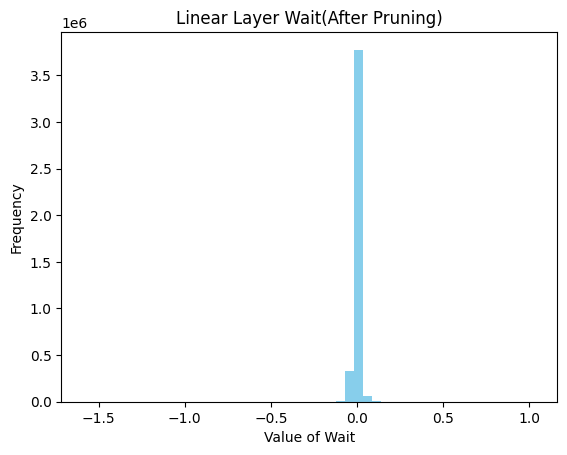

In [ ]:
import torch
import torch.nn.utils.prune as prune
import torch.nn as nn
import matplotlib.pyplot as plt

# 例: 1層目のLinear層の重み分布
layer = next(module for name, module in model.named_modules() if isinstance(module, nn.Linear))
weights = layer.weight.detach().cpu().numpy().flatten()

plt.hist(weights, bins=50, color="skyblue")
plt.title("Linear Layer Wait(After Pruning)")
plt.xlabel("Value of Wait")
plt.ylabel("Frequency")
plt.show()

##2.2 線形層に対して一括でプルーニング

In [ ]:
import torch
import torch.nn.utils.prune as prune

# モデル内の全てのLinear層にpruningを適用
for name, module in model.named_modules():
    if isinstance(module, torch.nn.Linear):
        prune.l1_unstructured(module, name="weight", amount=0.2)

##2.3 プルーニングの可視化例(After Pruning)

Before Pruning:
 Parameter containing:
tensor([[ 0.0471,  0.3095, -0.2609,  0.2869],
        [-0.0892,  0.1120, -0.4272, -0.3026],
        [ 0.2901,  0.0663, -0.3458, -0.0261],
        [ 0.4006, -0.1056,  0.4636,  0.3479]], requires_grad=True)


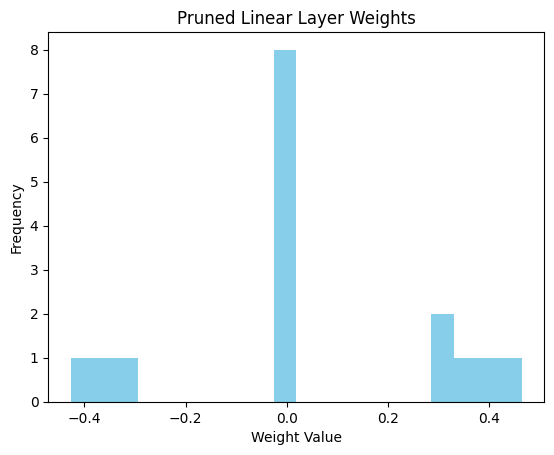

In [ ]:
import torch
import torch.nn.utils.prune as prune
import torch.nn as nn
import matplotlib.pyplot as plt

# 例: 適当なLinear層
linear = nn.Linear(4, 4)
print("Before Pruning:\n", linear.weight)

# Pruning適用
prune.l1_unstructured(linear, name="weight", amount=0.5)

# 【ポイント】Pruning後の実際の重み行列（= weight_orig * weight_mask）
pruned_weights = linear.weight_orig * linear.weight_mask
pruned_weights_flat = pruned_weights.detach().cpu().numpy().flatten()

# 可視化
plt.hist(pruned_weights_flat, bins=20, color="skyblue")
plt.title("Pruned Linear Layer Weights")
plt.xlabel("Weight Value")
plt.ylabel("Frequency")
plt.show()
